# Analysis of Oxygen stimulus data.

In [87]:
# General usage libraries
import os

# Numerical workhorses
import pandas as pd
import numpy as np
import scipy as scipy
import scipy.io as sio
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA

# Plotting 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import FuncFormatter
# Nice plots
import seaborn as sns

# favorite Seaborn settings for notebooks
rc={'lines.linewidth': 2, 
    'axes.facecolor' : 'F4F3F6',
    'axes.edgecolor' : '000000',
    'axes.linewidth' : 1.2,
    'grid.color' : 'a6a6a6',
    'lines.linewidth': 2,
    'axes.labelsize': 18,
    'axes.titlesize': 20,
    'xtick.major' : 13,
    'xtick.labelsize': 'large',
    'ytick.labelsize': 13,
    'font.family': 'Lucida Sans Unicode',
    'grid.linestyle': ':',
    'grid.linewidth': 1.5,
    'mathtext.fontset': 'stixsans',
    'mathtext.sf': 'sans',
    'legend.frameon': True,
    'legend.fontsize': 13}

plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
plt.rc('mathtext', fontset='stixsans', sf='sans')
sns.set_style('darkgrid', rc=rc)
sns.set_palette("colorblind", color_codes=True)
sns.set_context('notebook', rc=rc)


%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# Loading the data

Let's load and tidy the input GCaMP data.

In [62]:
# Define imaging rate
fps = 30.3 # frame / sec

# Initialize list to save frames
frames = []

# Loop through the files in directory
for root, dirs, files in\
    os.walk('../input/kato_data/nostim', topdown=False):
    for no_animals, file in enumerate(files):
        # Load the .mat file
        mat = sio.loadmat('../input/kato_data/nostim/' + file)
        # Convert neuron traces to numpy array
        npmat = np.array(mat['neuronTraces'].tolist())
        # Smooth the traces with a savgol filter
        smoothnpmat = savgol_filter(npmat, int(np.floor(fps) + 1), 2)
        # Extract neuron names to name columns in DataFrame
        columns = [a[0] for a in mat['neuronNames'][0]]
        # Generate pandas data frame with fluorescence traces
        temp = pd.DataFrame(npmat)
        # Generate data frame for smooth data
        temp2 = pd.DataFrame(smoothnpmat)
        # Define column names of data frames
        temp.columns = columns
        temp2.columns = columns
        
        # Add frame number using the index of the data frame
        temp['frame'] = temp.index
        
        # Melt the DataFrames into a tidy format
        melted_df = temp.melt(id_vars='frame', var_name='Neuron',
                         value_name='Fluorescence')
        smooth_melted_df = temp2.melt(var_name='Neuron',
                         value_name='Fluorescence')
        # Add column with animal index
        melted_df['animal'] = no_animals
        # Add smooth fluorescence
        melted_df['smooth_fluor'] = smooth_melted_df['Fluorescence']
        # Sort by neuron and frame
        melted_df.sort_values(['Neuron', 'frame'], inplace=True)
        # Put frames into a list for concatenation
        frames += [melted_df]

# Concatenate all DataFrames for each animal
df = pd.concat(frames)
df.head()

,frame,Neuron,Fluorescence,animal,smooth_fluor
55062,0,AIBL,1.354239,0,0.638887
55063,1,AIBL,1.296302,0,0.603887
55064,2,AIBL,1.265741,0,0.598448
55065,3,AIBL,1.156298,0,0.549912
55066,4,AIBL,1.091768,0,0.569109


Since not all neurons were labeled for each of the animals, let's identify the subset of neurons that were detected in all 3 samples.

In [64]:
# figure out subset of neurons with replicates:
# Initialize list to save neurons labeled in all samples
neurons_with_replicates = []
# Loop through data frames grouped by column neuron
for neuron, group in df.groupby('Neuron'):
    # List the index of unique animals
    animals = group.animal.unique()
    if len(animals) == df.animal.max() + 1:
        neurons_with_replicates += [neuron]
neurons_with_replicates = np.sort(neurons_with_replicates)
print(neurons_with_replicates)

['AIBL' 'AIBR' 'ALA' 'AVAL' 'AVAR' 'AVBL' 'AVBR' 'AVER' 'RIBL' 'RID' 'RIML'
 'RIMR' 'RIVL' 'RIVR' 'RMED' 'RMEL' 'RMER' 'SMDVR' 'VB01' 'VB02']


## Extracting data from each worm.

Given this list of neurons measured for all samples let's define a simple function that takes this list and an animal index and extracts the sub-DataFrame.

In [65]:
def get_data_from_worm(df, sample_idx, normed=True, smooth=False,
                       neuron_list=neurons_with_replicates):
    '''
    Extracts the data for a given sample containing only the neurons listed in
    neuron_list and returns a matrix with neurons as columns and frame as rows
    Parameters
    ----------
    df : Pandas DataFrame.
        Tidy data frame containing the neuron data with
        - Fluorescence values
        - Animal index
        - Neuron name
        - Frame number
    sample_idx : int.
        Sample index.
    normed : bool.
        Boolean indicating if the fluorescence data should be normalized before
        returning.
    smooth : bool.
        Boolean indicating if the raw data or the smooth data is to be returned.
    neuron_list : array-like.
        List of neurons to be included in the data frame
    '''
    # Take only rows containing the neurons included in neuron_list
    a = (df.Neuron.isin(neuron_list))
    
    # Extract data for desired sample
    if not smooth:
        single_animal = df[(df.animal == sample_idx) & a][['frame',
                                                           'Neuron', 
                                                           'Fluorescence']]
    else:
        single_animal = df[(df.animal == sample_idx) & a][['frame',
                                                           'Neuron', 
                                                           'smooth_fluor']]
    # Sort data by neuron name and frame number
#     single_animal.sort_values(['Neuron', 'frame'], inplace=True)
    
    # Pivot data frame
    single_animal = single_animal.pivot(index='frame', columns='Neuron')
    
    # Convert data into a matrix
    data = single_animal.as_matrix()
    
    if normed:
        data = (data - data.mean(axis=0))/data.std(axis=0)
    return data

### Exploratory analysis of animal zero.

Let's look at a single sample to build intuition on the structure of the data.

In [66]:
# Extract data from animal index 0
data0 = get_data_from_worm(df, 0, smooth=True)

Let's plot the neuronal traces over time as a heatmap.

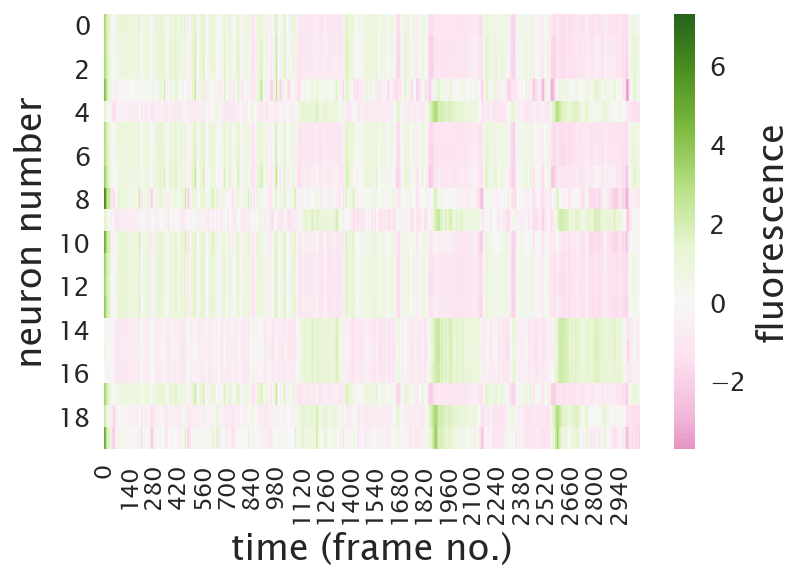

In [67]:
# Plot heat map of fluorescence centering the color bar at 0
sns.heatmap(data0.T, cmap='PiYG', center=0, cbar_kws={'label':'fluorescence'})
# Rotate ticks
_ = plt.yticks(rotation=0)
# Label axis
plt.xlabel('time (frame no.)')
plt.ylabel('neuron number')

There is definitely interesting structure in this heat map. Let's try clustering the most related neurons using `seaborn` clustermap on the convariance matrix.

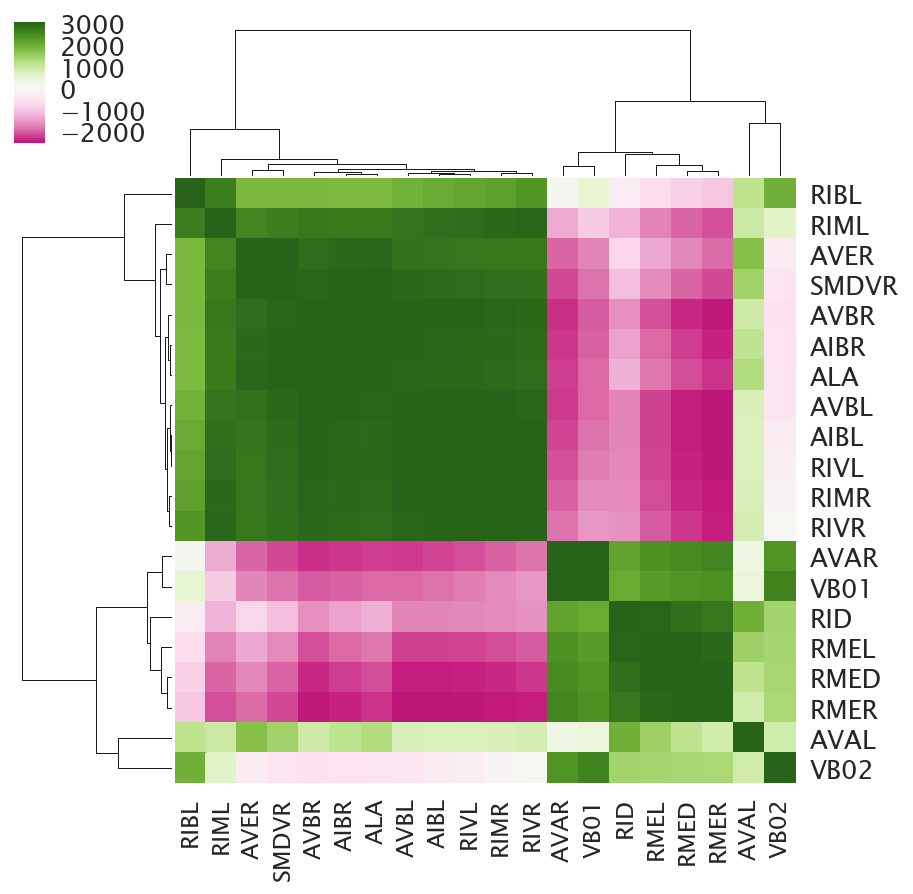

In [116]:
# Compute the covariance matrix
covar = data0.T.dot(data0)

covar = pd.DataFrame(covar, columns=neurons_with_replicates,
                     index=neurons_with_replicates)
cg = sns.clustermap(covar.as_matrix(), cmap="PiYG", figsize=(7, 7),
                    **{'center':0})
temp = cg.ax_heatmap.get_xticklabels()

# Generate dictionary to convert numerical label to neuron name
neuron_dict = {i: neurons for i, neurons in enumerate(neurons_with_replicates)}

# Extract labels from both axis
xlabels = [item.get_text() for item in cg.ax_heatmap.xaxis.get_ticklabels()]
ylabels = [item.get_text() for item in cg.ax_heatmap.yaxis.get_ticklabels()]

# Map labels to neuron name given the dictionary
cg.ax_heatmap.xaxis.set_ticklabels([neuron_dict[y] for y in
                                    [int(x) for x in xlabels]])
cg.ax_heatmap.yaxis.set_ticklabels([neuron_dict[y] for y in
                                    [int(x) for x in ylabels]])

# Rotate labels in x axis
_ = plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)

['RIBL',
 'RIML',
 'AVER',
 'SMDVR',
 'AVBR',
 'AIBR',
 'ALA',
 'AVBL',
 'AIBL',
 'RIVL',
 'RIMR',
 'RIVR',
 'AVAR',
 'VB01',
 'RID',
 'RMEL',
 'RMED',
 'RMER',
 'AVAL',
 'VB02']

In [53]:
covar['coNeuron'] = covar.index
melt_covar = covar.melt(id_vars='coNeuron', var_name='Neuron', value_name='covariance')
melt_covar[melt_covar.covariance > np.percentile(melt_covar.covariance, 99)]

,coNeuron,Neuron,covariance
126,AVBR,AVBR,3059.0
189,RID,RID,3059.0
315,RMEL,RMEL,3059.0
399,VB02,VB02,3059.0


In [54]:
data1, columns1 = get_data_from_worm(1)
data2, columns2 = get_data_from_worm(2)
subset = data0
pca = PCA(3)
pca.fit(subset)
print(pca.explained_variance_ratio_)
W = pca.components_

['AIBL_smooth' 'AIBR_smooth' 'ALA_smooth' 'AVAL_smooth' 'AVAR_smooth'
 'AVBL_smooth' 'AVBR_smooth' 'AVER_smooth' 'RIBL_smooth' 'RID_smooth'
 'RIML_smooth' 'RIMR_smooth' 'RIVL_smooth' 'RIVR_smooth' 'RMED_smooth'
 'RMEL_smooth' 'RMER_smooth' 'SMDVR_smooth' 'VB01_smooth' 'VB02_smooth']
['AIBL_smooth' 'AIBR_smooth' 'ALA_smooth' 'AVAL_smooth' 'AVAR_smooth'
 'AVBL_smooth' 'AVBR_smooth' 'AVER_smooth' 'RIBL_smooth' 'RID_smooth'
 'RIML_smooth' 'RIMR_smooth' 'RIVL_smooth' 'RIVR_smooth' 'RMED_smooth'
 'RMEL_smooth' 'RMER_smooth' 'SMDVR_smooth' 'VB01_smooth' 'VB02_smooth']
[0.71152528 0.20207151 0.08568088]


In [55]:
tD0 = W.dot(data0.T)
tD1 = W.dot(data1.T)
tD2 = W.dot(data2.T)

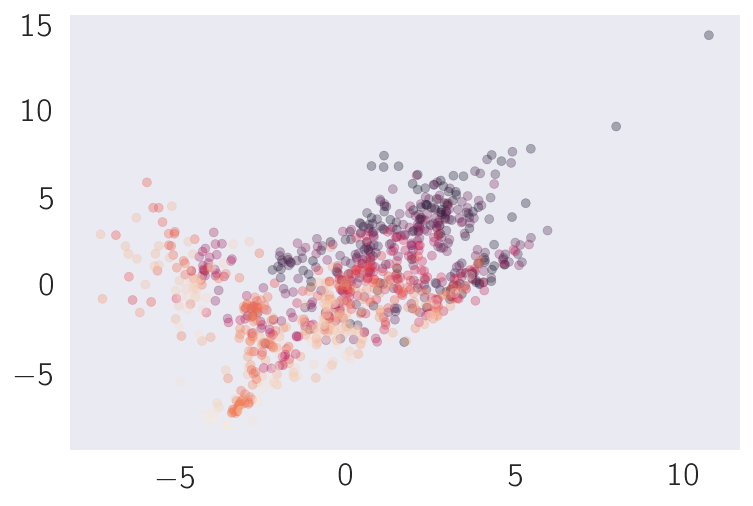

In [58]:
subsample = 10
color = np.linspace(0, 1, len(tD0[0, ::subsample]))
color1 = np.linspace(0, 1, len(tD1[0, ::subsample]))
color2 = np.linspace(0, 1, len(tD2[0, ::subsample]))

plt.scatter(tD0[0, ::subsample], tD0[1, ::subsample], s=20, alpha=0.3, c=color)
plt.scatter(tD1[0, ::subsample], tD1[1, ::subsample], s=20, alpha=0.3, c=color1)
plt.scatter(tD2[0, ::subsample], tD2[1, ::subsample], s=20, alpha=0.3, c=color2)

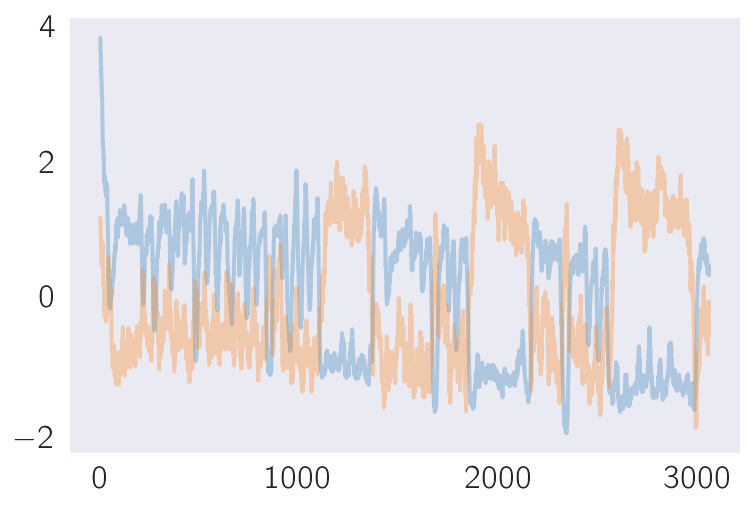

In [73]:
plt.plot(data0[:, 0], alpha=0.3)
plt.plot(data0[:, 15], alpha=0.3)

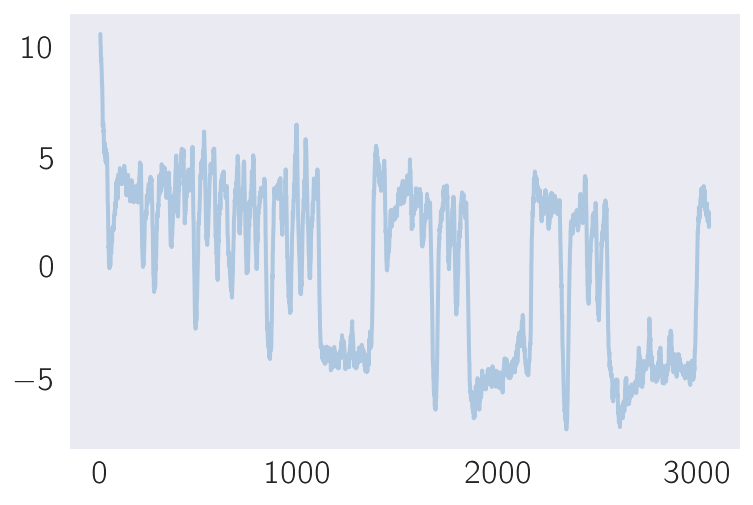

In [67]:
plt.plot(tD0[0, :], alpha=0.3)